# Mid-semester assignment - Advanced topics in deep learning
Hello dear students,<br> this is the template notebook. Please upload it into your drive and open as Google Colab nootebook".

---
<br>

### Name and ID:
Student 1: Ori Malca 315150599
<br>
Student 2: Kfir Sitalkil 208722660

## Coffee Bean Classification Project
The project is a classification of images on "coffee bean dataset resized". It is a computer vision project that classifies the coffee beans by looking their colours. There are 4 labels that are Dark, Green, Light and Medium.

<table>
  <tr><td>
    <img src="https://i.pinimg.com/564x/70/24/98/702498e0289cd18be9c160eb81357b30.jpg"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  
</table>



**The Data**<br>
The dataset is labeled into 4 different classes.

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Dark</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Green</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Light</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Medium</td>
  </tr>
</table>
<br>


# Goodluck!

## Part 0 -  Utiles

### Import Libraries

In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
import os
import pathlib
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, multilabel_confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay

!pip install -U --no-cache-dir gdown --pre
!gdown --id 1anU5YH4vRueTEF-ZGGDEDvEY4FNfSOjF
!unzip /content/archive.zip
!gdown --version

## Part 1 - Data Preprocessing

### Data exploration

How many classes do we have?



In [ ]:
%%script echo skipping
num_of_coffee_bean_classes = len(os.listdir('/content/train'))
print(f'There are {num_of_coffee_bean_classes} different classes')

There are 4 different classes


What are those classes?

In [ ]:
%%script echo skipping
data_dir = pathlib.Path('/content/train')
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(f'Name of classes:\n{class_names}')

Name of classes:
['Dark' 'Green' 'Light' 'Medium']


Let's create a function to visualize images randomly

In [ ]:
%%script echo skipping
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + '/' + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}')
  
  return img

Let's visualize images from all categories



Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


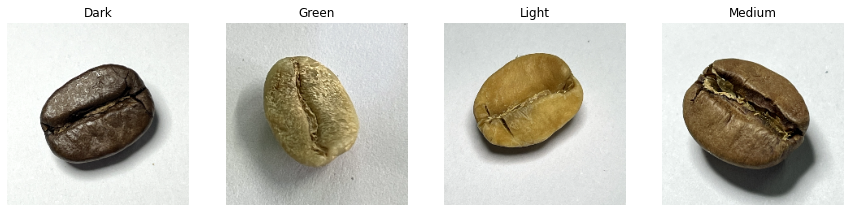

In [ ]:
%%script echo skipping
plt.figure(figsize = (15,7))
plt.subplot(1,4,1)
dark_bean_image = view_random_image('/content/train/', "Dark")
plt.subplot(1,4,2)
green_bean_image = view_random_image('/content/train/', "Green")
plt.subplot(1,4,3)
light_bean_image = view_random_image('/content/train/', "Light")
plt.subplot(1,4,4)
medium_bean_image = view_random_image('/content/train/', "Medium")

Lets's see what the csv file contains

In [ ]:
%%script echo skipping
df = pd.read_csv('/content/Coffee Bean.csv')
df.head()

,class index,filepaths,labels,data set
0,0,train/Dark/dark (1).png,Dark,train
1,0,train/Dark/dark (10).png,Dark,train
2,0,train/Dark/dark (100).png,Dark,train
3,0,train/Dark/dark (101).png,Dark,train
4,0,train/Dark/dark (102).png,Dark,train


**From here you will have to continue on your own. Goodluck!**

### Manipulating the data
Operations performed on the data:
1. Extracting the train set and test set
2. Augmenting the train set
3. Normalizing the train set and the test set by 1/255
3. One-Hot Encoding the labels of the train set and test set

Note on keras.ImageDataGenerator:

By default, keras.ImageDataGenerator performs in-place/on-the-fly/real-time data augmentation, so we must not augment the test data beucase we will get
differenet results(loss/accuracy) on the test set everytime we evaluate our model against it(since we get a new different random augmentet test set from the original test data each time)

In [ ]:
%%script echo skipping
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory('/content/train',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

validation_generator = train_datagen.flow_from_directory('/content/train',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         subset='validation',
                                                         shuffle=True)

# extracting test data for evaluation:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('/content/test',
                                                  target_size = (224, 224),
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  shuffle=False)

# extracting test data for prediction and classification report:
itr_test = test_datagen.flow_from_directory('/content/test',
                                            target_size = (224, 224),
                                            batch_size=400,
                                            class_mode='sparse',
                                            shuffle=False)
X_test, Y_test = itr_test.next()

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


## Part 2 - Model Architecture and Training

In [ ]:
%%script echo skipping
# for saving models information later on
models_names = ['Base Model', 'Experiment 1 Model', 'Final Model']
models, histories = [], []

### Building the Base Model - CNN

In [ ]:
%%script echo skipping
base_model = keras.models.Sequential([
  keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
  keras.layers.MaxPool2D(pool_size=2, strides=2),
  keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  keras.layers.MaxPool2D(pool_size=2, strides=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=28, activation='relu'),
  keras.layers.Dense(units=4, activation='softmax')
])
base_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])
base_model_batch_size = 32
base_model_no_epochs = 10

models.append(base_model)

base_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 93312)             0         
                                                                 
 dense_12 (Dense)            (None, 28)               

#### Training the Base Model on the Training set

In [ ]:
%%script echo skipping
base_model_history = base_model.fit(x=train_generator, validation_data=validation_generator,
                                    epochs=base_model_no_epochs,
                                    steps_per_epoch=len(train_generator),
                                    validation_steps=int(0.25*len(validation_generator)))
histories.append(base_model_history)

Epoch 1/10
30/30 [==============================] - 78s 3s/step - loss: 1.3882 - accuracy: 0.2875 - val_loss: 1.3598 - val_accuracy: 0.3281
Epoch 2/10
30/30 [==============================] - 60s 2s/step - loss: 1.3647 - accuracy: 0.2979 - val_loss: 1.3617 - val_accuracy: 0.4688
Epoch 3/10
30/30 [==============================] - 61s 2s/step - loss: 1.3306 - accuracy: 0.3448 - val_loss: 1.3907 - val_accuracy: 0.2344
Epoch 4/10
30/30 [==============================] - 62s 2s/step - loss: 1.2959 - accuracy: 0.3604 - val_loss: 1.2407 - val_accuracy: 0.3281
Epoch 5/10
30/30 [==============================] - 60s 2s/step - loss: 1.2332 - accuracy: 0.4198 - val_loss: 1.2655 - val_accuracy: 0.5625
Epoch 6/10
30/30 [==============================] - 59s 2s/step - loss: 1.1933 - accuracy: 0.4469 - val_loss: 1.2566 - val_accuracy: 0.3906
Epoch 7/10
30/30 [==============================] - 62s 2s/step - loss: 1.2017 - accuracy: 0.4281 - val_loss: 1.2234 - val_accuracy: 0.4531
Epoch 8/10
30/30 [==

### Experiment 1 - Changing the Architecture of the Base Model

In [ ]:
%%script echo skipping
exp1_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=4, activation='softmax')
])
exp1_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])
exp1_model_batch_size = 32
exp1_model_no_epochs = 10

models.append(exp1_model)

exp1_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 93312)             0         
                                                                 
 dense_14 (Dense)            (None, 64)               

#### Training Experiment 1 Model on the Training set

In [ ]:
%%script echo skipping
exp1_model_history = exp1_model.fit(x=train_generator, validation_data=validation_generator,
                                    epochs=exp1_model_no_epochs,
                                    steps_per_epoch=len(train_generator),
                                    validation_steps=int(0.25*len(validation_generator)))
histories.append(exp1_model_history)

Epoch 1/10
30/30 [==============================] - 64s 2s/step - loss: 1.3621 - accuracy: 0.3281 - val_loss: 1.3269 - val_accuracy: 0.3594
Epoch 2/10
30/30 [==============================] - 60s 2s/step - loss: 1.2634 - accuracy: 0.4073 - val_loss: 1.1374 - val_accuracy: 0.4531
Epoch 3/10
30/30 [==============================] - 60s 2s/step - loss: 1.0672 - accuracy: 0.5177 - val_loss: 1.0867 - val_accuracy: 0.4375
Epoch 4/10
30/30 [==============================] - 63s 2s/step - loss: 0.8300 - accuracy: 0.6490 - val_loss: 1.0271 - val_accuracy: 0.5156
Epoch 5/10
30/30 [==============================] - 60s 2s/step - loss: 0.7044 - accuracy: 0.7104 - val_loss: 0.6061 - val_accuracy: 0.8594
Epoch 6/10
30/30 [==============================] - 60s 2s/step - loss: 0.5929 - accuracy: 0.7750 - val_loss: 0.5467 - val_accuracy: 0.7812
Epoch 7/10
30/30 [==============================] - 62s 2s/step - loss: 0.4623 - accuracy: 0.8156 - val_loss: 0.3696 - val_accuracy: 0.9531
Epoch 8/10
30/30 [==

### Experiment 2 - Changing the Architecture of Experiment 1 Model - Creating the Final Model

In [ ]:
%%script echo skipping
final_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=4, activation='softmax')
])
final_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
final_model_batch_size = 32
final_model_no_epochs = 10

models.append(final_model)

final_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 93312)             0         
                                                                 
 dense_16 (Dense)            (None, 64)               

#### Training the Final Model (Experiment 2 Model) on the Training set

In [ ]:
%%script echo skipping
final_model_history = final_model.fit(x=train_generator, validation_data=validation_generator,
                                      epochs=final_model_no_epochs,
                                      steps_per_epoch=len(train_generator),
                                      validation_steps=int(0.25*len(validation_generator)))
histories.append(final_model_history)

Epoch 1/10
30/30 [==============================] - 61s 2s/step - loss: 1.8030 - accuracy: 0.4615 - val_loss: 0.6856 - val_accuracy: 0.7031
Epoch 2/10
30/30 [==============================] - 60s 2s/step - loss: 0.3133 - accuracy: 0.8917 - val_loss: 0.2026 - val_accuracy: 0.9375
Epoch 3/10
30/30 [==============================] - 60s 2s/step - loss: 0.1132 - accuracy: 0.9656 - val_loss: 0.1391 - val_accuracy: 0.9531
Epoch 4/10
30/30 [==============================] - 60s 2s/step - loss: 0.1209 - accuracy: 0.9521 - val_loss: 0.2035 - val_accuracy: 0.8906
Epoch 5/10
30/30 [==============================] - 60s 2s/step - loss: 0.0785 - accuracy: 0.9781 - val_loss: 0.0874 - val_accuracy: 0.9688
Epoch 6/10
30/30 [==============================] - 60s 2s/step - loss: 0.0468 - accuracy: 0.9823 - val_loss: 0.1253 - val_accuracy: 0.9375
Epoch 7/10
30/30 [==============================] - 63s 2s/step - loss: 0.0826 - accuracy: 0.9698 - val_loss: 0.1519 - val_accuracy: 0.9375
Epoch 8/10
30/30 [==

## Part 3 - Results and Evaluation Metrics

In [ ]:
%%script echo skipping
def plot_curves(model_name, history, metric, validation=False):
    epochs = range(len(history.history[metric]))

    plt.plot(epochs, history.history[metric], label=f'training_{metric}')
    if validation:
      plt.plot(epochs, history.history[f'val_{metric}'], label=f'val_{metric}')
      plt.legend()
    
    plt.title(f'{model_name} {metric}:')
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.figure()

### Visualization of the Loss of training

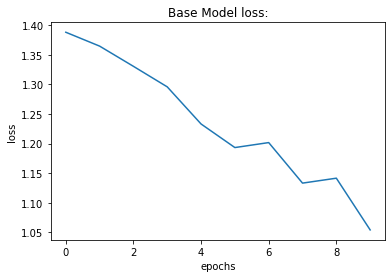

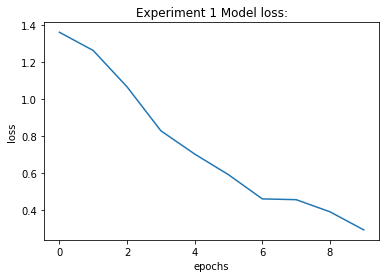

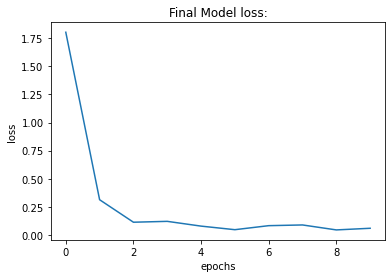

<Figure size 432x288 with 0 Axes>

In [ ]:
%%script echo skipping
for i in range(3):
  plot_curves(model_name=models_names[i], history=histories[i], metric='loss')

### Visualization of the Accuracy of training

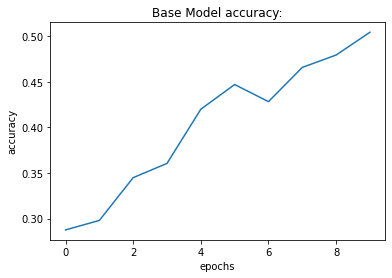

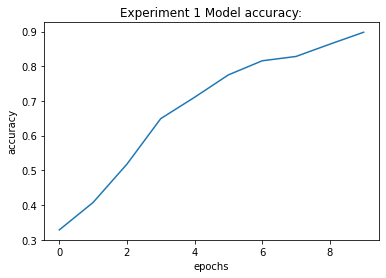

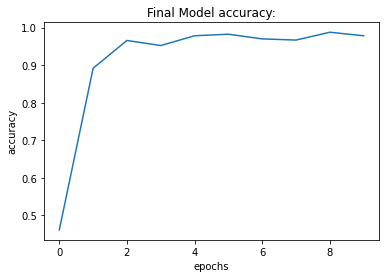

<Figure size 432x288 with 0 Axes>

In [ ]:
%%script echo skipping
for i in range(3):
  plot_curves(model_name=models_names[i], history=histories[i], metric='accuracy')

### Visualization of the Loss of validation VS loss of training

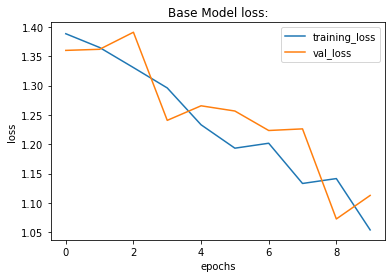

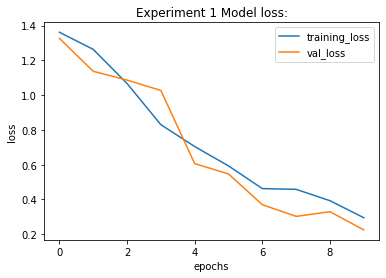

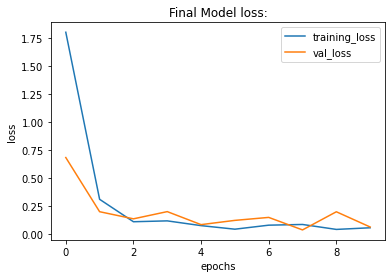

<Figure size 432x288 with 0 Axes>

In [ ]:
%%script echo skipping
for i in range(3):
  plot_curves(model_name=models_names[i], history=histories[i], metric='loss', validation=True)

### Visualization of the Accuracy of validation VS Accuracy of training

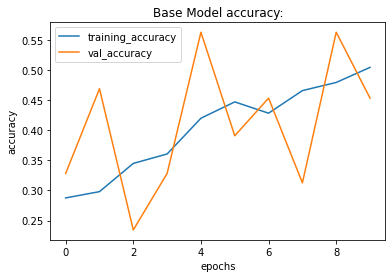

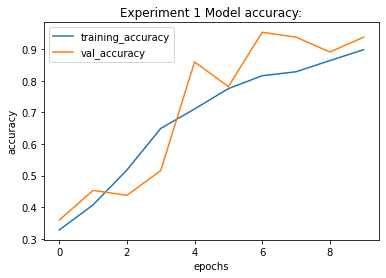

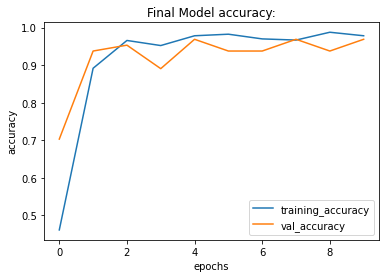

<Figure size 432x288 with 0 Axes>

In [ ]:
%%script echo skipping
for i in range(3):
  plot_curves(model_name=models_names[i], history=histories[i], metric='accuracy', validation=True)

### Making the predictions and evaluating the model

### Predicting the Test set results

In [ ]:
%%script echo skipping
predictions = []

print('------------------------------------------------------------------------')
for i in range(3):
  pred = np.argmax(models[i].predict(X_test), axis=1)
  predictions.append(pred)
  print(f'{models_names[i]} Predictions:\n{pred}')
  print('------------------------------------------------------------------------')

------------------------------------------------------------------------
13/13 [==============================] - 5s 399ms/step
Base Model Predictions:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 0 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 1 1 2 1 1 1 1 0 1 0 0 1 1 1 1 3 0
 3 1 1 1 1 1 2 1 0 0 1 0 3 0 0 3 1 1 3 0 0 1 1 0 1 1 1 1 1 1 1 1 1 2 0 1 1
 1 1 3 1 1 1 1 3 1 1 1 2 3 2 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 0 1 1 1 1 2 1
 1 2 1 1 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
------------------------------------

### Accuracy and Loss on Test set

In [ ]:
%%script echo skipping
print('------------------------------------------------------------------------')
for i in range(3):
  print(f'{models_names[i]}:')
  test_loss, test_accuracy = models[i].evaluate(test_generator, verbose=0)
  balanced_accuracy = balanced_accuracy_score(predictions[i], Y_test.astype('int32'))
  print(f'loss on test set: {test_loss}')
  print(f'accuracy on test set: {test_accuracy}')
  print(f'balanced accuracy on test set: {balanced_accuracy}')
  print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Base Model:
loss on test set: 1.0431958436965942
accuracy on test set: 0.512499988079071
balanced accuracy on test set: 0.47982893487279454
------------------------------------------------------------------------
Experiment 1 Model:
loss on test set: 0.17629779875278473
accuracy on test set: 0.949999988079071
balanced accuracy on test set: 0.9507346050551728
------------------------------------------------------------------------
Final Model:
loss on test set: 0.02453027479350567
accuracy on test set: 0.987500011920929
balanced accuracy on test set: 0.9876222916409289
------------------------------------------------------------------------


### Making the Classification Report

In [ ]:
%%script echo skipping
print('------------------------------------------------------------------------')
for i in range(3):
  print(f'The Classification Report of the {models_names[i]}:')
  print(classification_report(predictions[i], Y_test.astype('int32')))
  print('------------------------------------------------------------------------')

------------------------------------------------------------------------
The Classification Report of the Base Model:
              precision    recall  f1-score   support

           0       0.99      0.47      0.64       209
           1       0.94      0.58      0.72       162
           2       0.08      0.62      0.14        13
           3       0.04      0.25      0.07        16

    accuracy                           0.51       400
   macro avg       0.51      0.48      0.39       400
weighted avg       0.90      0.51      0.63       400

------------------------------------------------------------------------
The Classification Report of the Experiment 1 Model:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        95
           1       0.97      0.96      0.97       101
           2       0.99      0.93      0.96       107
           3       0.90      0.93      0.91        97

    accuracy                           0.95      

### Making the Multilabel Confusion Matrix

In [ ]:
%%script echo skipping
print('------------------------------------------------------------------------')
for i in range(3):
  print(f'The Multilabel Confusion Matrix of the {models_names[i]}:')
  print(multilabel_confusion_matrix(predictions[i], Y_test.astype('int32')))
  print('------------------------------------------------------------------------')

------------------------------------------------------------------------
The Multilabel Confusion Matrix of the Base Model:
[[[190   1]
  [110  99]]

 [[232   6]
  [ 68  94]]

 [[295  92]
  [  5   8]]

 [[288  96]
  [ 12   4]]]
------------------------------------------------------------------------
The Multilabel Confusion Matrix of the Experiment 1 Model:
[[[299   6]
  [  1  94]]

 [[296   3]
  [  4  97]]

 [[292   1]
  [  8  99]]

 [[293  10]
  [  7  90]]]
------------------------------------------------------------------------
The Multilabel Confusion Matrix of the Final Model:
[[[299   2]
  [  1  98]]

 [[300   2]
  [  0  98]]

 [[298   0]
  [  2 100]]

 [[298   1]
  [  2  99]]]
------------------------------------------------------------------------


## Part 4 - Test Environment

### Saving model to drive

In [ ]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/gdrive')

final_model.save('/content/gdrive/My Drive/Colab Notebooks/final_model_mid_sem_adv_dl.h5')

Mounted at /content/gdrive


### Downloading saved model

In [ ]:
!gdown --id 1jpH_pLio7cES4uz42zS22LSk2CnXW-hb
!unzip /content/my_files.zip

### Loading trained model 

In [ ]:
model = keras.models.load_model('/content/final_model_mid_sem_adv_dl.h5')

### Uploading files from your local file system

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

### Predicting the result of a single observation
This function gets a normalized image(between 0 and 1) as a numpy array and returns the prediction for this image

In [ ]:
def single_predictor(model, sample):
  '''tests the model on a single sample'''
  prediction = model.predict(sample)
  print(f'prediction: {prediction}')
  print(f'Dark: {prediction[0,0]}, Green: {prediction[0,1]}, Light: {prediction[0,2]}, Medium: {prediction[0,3]}')
  print('The model predicted: ' + {0: 'Dark', 1: 'Green', 2: 'Light', 3: 'Medium'}.get(np.argmax(prediction)))

### Test model

Note on matplotlib.pyplot.imread:

matplotlib.mpimg.imread already normalizing the images for us, so no need to normalize the images after using matplotlib.mpimg.imread

In [ ]:
filename = next(iter(uploaded))
sample = np.array([mpimg.imread(f'/content/{filename}')])

In [ ]:
single_predictor(model, sample)